Basic Predictions
===============

This notebook tries to predict number of "confirmed cases" from patientdb available at http://api.covid19india.org/. 

Growth rate is computed as rate of change of confirmed cases and smoothened using a 7d rolling average.
It is extrapolated using the following methods:
* Quadartic curve fitting - fails to fit the curve correctly
* Hyperbolic curve fitting using a neural net - fits well and asymptotes the growth rate at ~7%.

The model is rudimentary and points towards a scenario where we fail to contain the epidemic and it eventually moves to stage 3/4.

In [132]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib as mpl

import datetime as dt
import pandas as pd
import numpy as np
import requests

from sklearn.neural_network import MLPRegressor

In [3]:
# download patient data
r = requests.get("https://api.covid19india.org/raw_data.json")
o = r.json()
df_orig = pd.DataFrame(o['raw_data'])

In [5]:
# format and clean
df_orig['dateannounced'] = pd.to_datetime(df_orig['dateannounced'], format="%d/%m/%Y")
df = df_orig[(df_orig.currentstatus!="") & (df_orig.detectedstate!="")]
print(len(df))

27890


In [6]:
# inspect
print(df.columns)
print(df.currentstatus.value_counts())

Index(['agebracket', 'backupnotes', 'contractedfromwhichpatientsuspected',
       'currentstatus', 'dateannounced', 'detectedcity', 'detecteddistrict',
       'detectedstate', 'estimatedonsetdate', 'gender', 'nationality', 'notes',
       'patientnumber', 'source1', 'source2', 'source3', 'statecode',
       'statepatientnumber', 'statuschangedate', 'typeoftransmission'],
      dtype='object')
Hospitalized    27662
Recovered         181
Deceased           46
Migrated            1
Name: currentstatus, dtype: int64


,daily,total,growth,sma_growth
dateannounced,,,,
2020-04-22,1292,21373,6.433943,8.131696
2020-04-23,1667,23040,7.799560,8.020703
2020-04-24,1408,24448,6.111111,7.913118
2020-04-25,1835,26283,7.505726,7.620887
2020-04-26,1607,27890,6.114218,7.058962


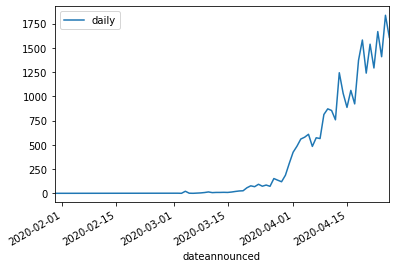

In [135]:
by_date = df.groupby(by='dateannounced')['patientnumber'].count().to_frame()
by_date = by_date.rename(columns={'patientnumber': 'daily'})

# cum sum
cumsum = by_date.cumsum()
by_date['total'] = cumsum['daily']

# calc growth rate & its moving avg
by_date['growth'] = 100 * by_date['daily'] / (by_date['total'] - by_date['daily'])
sma_gr = by_date['growth'].rolling('7d').mean()
by_date['sma_growth'] = sma_gr

# daily plot
by_date.plot(y='daily', kind='line')
by_date.tail()

In [207]:
# create extrapolation dataframe
last_date = by_date.index[-1]
projections = pd.DataFrame(index=by_date.index.union(pd.date_range(start=last_date, periods=150, freq="1d")))

# fill with orig df
projections['daily'] = by_date['daily']
projections['total'] = by_date['total']
projections['sma_growth'] = by_date['sma_growth']
projections['day_of_yr'] = projections.index.dayofyear

# filter data for curve fitting (aka training data)
end_idx = len(by_date)
start_idx = end_idx - 21 # use 21 day sma data for curve fitting
fit_df = projections[start_idx:end_idx]
fit_df.tail()

,daily,total,sma_growth,day_of_yr
2020-04-22,1292.0,21373.0,8.131696,113
2020-04-23,1667.0,23040.0,8.020703,114
2020-04-24,1408.0,24448.0,7.913118,115
2020-04-25,1835.0,26283.0,7.620887,116
2020-04-26,1607.0,27890.0,7.058962,117


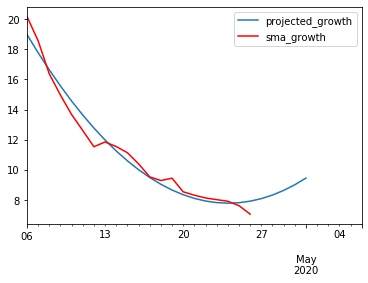

In [208]:
# fit polynomial curve
coeffs = np.polyfit(fit_df.day_of_yr, fit_df.sma_growth, 2) # 2nd degree
extrapolation_eqn = np.poly1d(coeffs)
projections['projected_growth'] = extrapolation_eqn(projections.day_of_yr)
ax = projections[start_idx:end_idx+5].plot(y='projected_growth', grid=True)
projections[start_idx:end_idx+10].plot(y='sma_growth', color='red', ax=ax)

In [158]:
# train a neural network with hyperbolic activation function from day_of_yr => sma_growth
regressor = MLPRegressor(hidden_layer_sizes = (100,), activation = 'tanh', solver='lbfgs', max_iter=500)
regressor.fit(X=fit_df[['day_of_yr']], y=fit_df['sma_growth'])

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=500, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

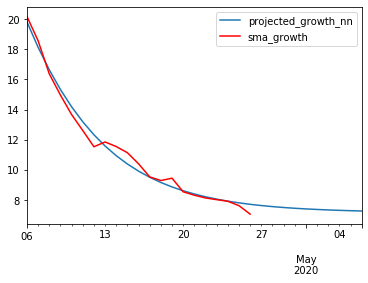

In [209]:
projections['projected_growth_nn'] = regressor.predict(X=projections[['day_of_yr']])
ax = projections[start_idx:end_idx+10].plot(y='projected_growth_nn', grid=True)
projections[start_idx:end_idx+10].plot(y='sma_growth', color='red', ax=ax)

In [210]:
# compute total and daily numbers based on projected rate
prev_row_total = 0
def project(row):
    global prev_row_total
    if not np.isnan(row['total']):
        prev_row_total = row['total']
        return row['total']
    prev_row_total *= (1 + row['projected_growth_nn']/100)
    return prev_row_total

projections['projected_total'] = projections.apply(project, axis=1).astype('int64')

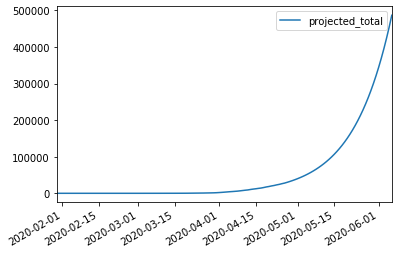

In [213]:
# plot 100 days from feb 1
projections[0:100].plot(y='projected_total')

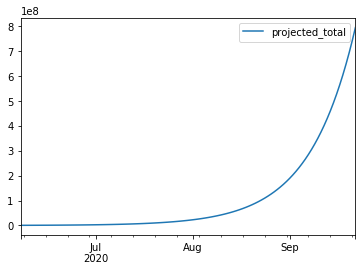

In [214]:
# plot 100 days to Oct  
projections[100:].plot(y='projected_total')